# Setting

In [1]:
import pandas as pd
import torch
import random
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import numpy as np

from models.shared_perceiver import CustomDataset, Perceiver, CombinedModel

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

file_path = '/home/youlee/n24news/n24news/captions_and_labels.csv'
data = pd.read_csv(file_path)

groups = [
    ["Opinion", "Art & Design", "Television"],
    ["Music", "Travel", "Real Estate"],
    ["Books", "Theater", "Health"],
    ["Sports", "Science", "Food"],
    ["Fashion & Style", "Movies", "Technology"],
    ["Dance", "Media", "Style"]
]

output_paths = []
for i, group_labels in enumerate(groups, 1):
    group_data = data[data['Label'].isin(group_labels)]
    output_path = f'/home/youlee/n24news/n24news/regroup_{i}.csv'
    group_data.to_csv(output_path, index=False)
    output_paths.append(output_path)

print("생성된 그룹별 CSV 파일 경로:")
for path in output_paths:
    print(path)

생성된 그룹별 CSV 파일 경로:
/home/youlee/n24news/n24news/regroup_1.csv
/home/youlee/n24news/n24news/regroup_2.csv
/home/youlee/n24news/n24news/regroup_3.csv
/home/youlee/n24news/n24news/regroup_4.csv
/home/youlee/n24news/n24news/regroup_5.csv
/home/youlee/n24news/n24news/regroup_6.csv


In [2]:
def seed_everything(seed):
    torch.manual_seed(seed) #torch를 거치는 모든 난수들의 생성순서를 고정한다
    torch.cuda.manual_seed(seed) #cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다 
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True #딥러닝에 특화된 CuDNN의 난수시드도 고정 
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) #numpy를 사용할 경우 고정
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정

def seed_worker(worker_id): #데이터로더 난수고정
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(42)
g = torch.Generator()
g.manual_seed(42)
NUM_WORKERS = 4 # 서브프로세스관리자 수. 난수생성과 관련있습니다. 일단은 4로 고정합니다.


In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128

In [4]:
def tokenize_data(df, tokenizer=BertTokenizer.from_pretrained('bert-base-uncased'), MAX_LENGTH=128):
    input_ids, attention_masks = [], []
    df['Caption'] = df['Caption'].astype(str).fillna("")

    for text in df['Caption']:
        encoded = tokenizer(
            text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze(0))
        attention_masks.append(encoded['attention_mask'].squeeze(0))
    return torch.stack(input_ids), torch.stack(attention_masks)


# Functions

In [5]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)  
        labels = batch['labels'].to(device)
        #print(f"🚀 input_ids.shape: {input_ids.shape}") 
        optimizer.zero_grad()
        outputs = model(input_ids)  # CombinedModel의 forward 호출
        loss = criterion(outputs, labels)
        #print(f"🚀 outputs.shape: {outputs.shape}")
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)  
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [6]:
model_path = '/home/Minju/Perceiver/shared_layer_model'
loader_path = '/home/Minju/Perceiver/loader'

In [7]:
for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)
    sample = dataset [0]
    print(sample)
    print(len(dataset)) 

    dataloader = DataLoader(dataset, batch_size=2, shuffle=False, 
                            num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=g)
    first_batch = next(iter(dataloader))
    print(first_batch)
 


group 1 처리 중...
{'input_ids': tensor([ 101, 1996, 2317, 2160, 2003, 1037, 4556, 2806, 3538, 1997, 4294, 1010,
        4427, 2011, 3306, 1998, 3142, 3121, 1012,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0,

# Train 시작


group 1 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1013, train acc: 0.3470
                               test loss: 1.1008, test acc: 0.3296
    epoch 5/40: train loss: 0.8379, train acc: 0.5858
                               test loss: 0.7977, test acc: 0.6037
    epoch 10/40: train loss: 0.7737, train acc: 0.6563
                               test loss: 0.7506, test acc: 0.6754
    epoch 15/40: train loss: 0.7398, train acc: 0.6777
                               test loss: 0.7302, test acc: 0.6745
    epoch 20/40: train loss: 0.7234, train acc: 0.6873
                               test loss: 0.7190, test acc: 0.6830
    epoch 25/40: train loss: 0.7164, train acc: 0.6920
                               test loss: 0.7198, test acc: 0.6855
    epoch 30/40: train loss: 0.7130, train acc: 0.6997
                               test loss: 0.7192, test acc: 0.6861
    epoch 35/40: train loss: 0.7118, train acc: 0.7008
                               test loss: 0.7151, test a

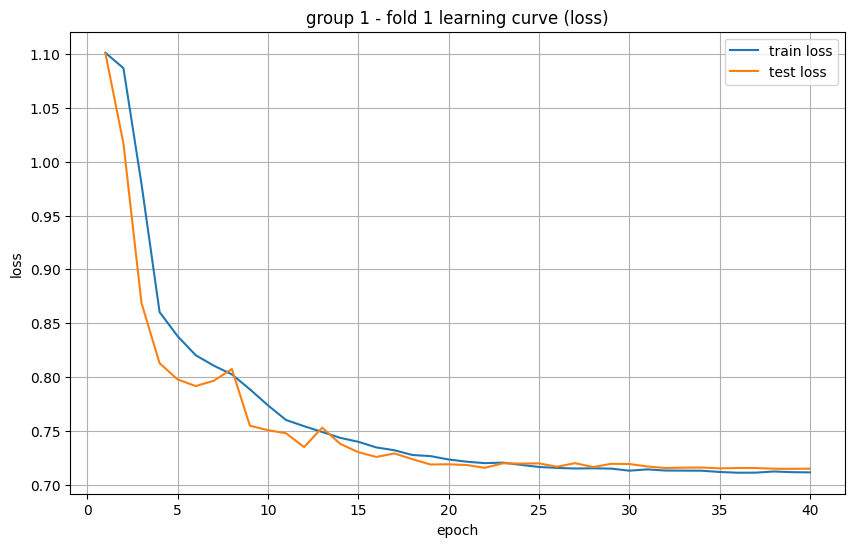

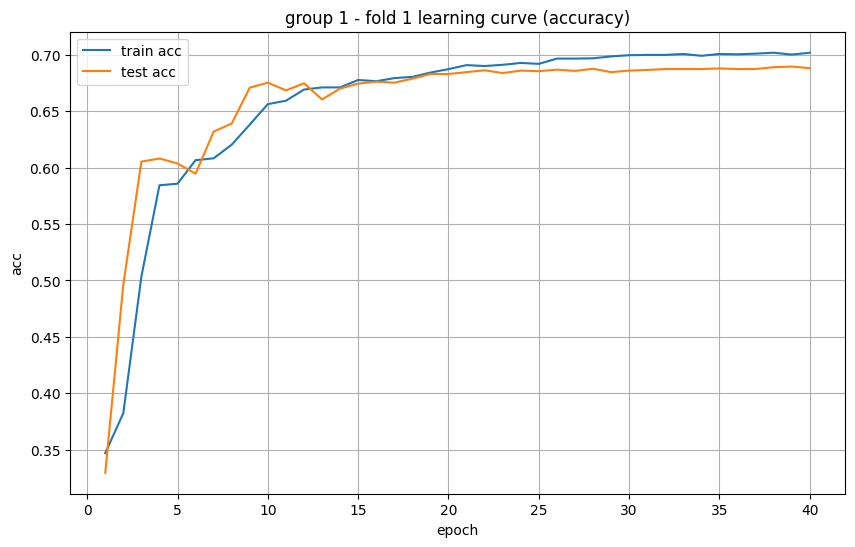

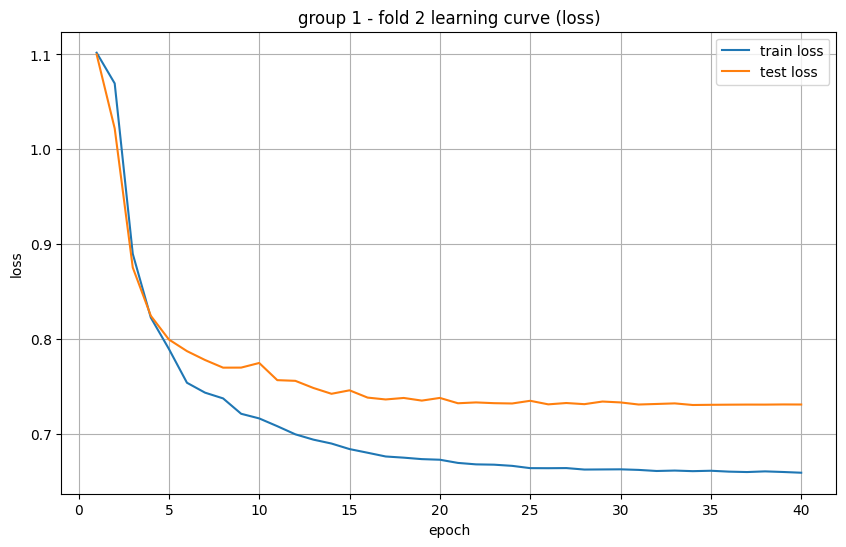

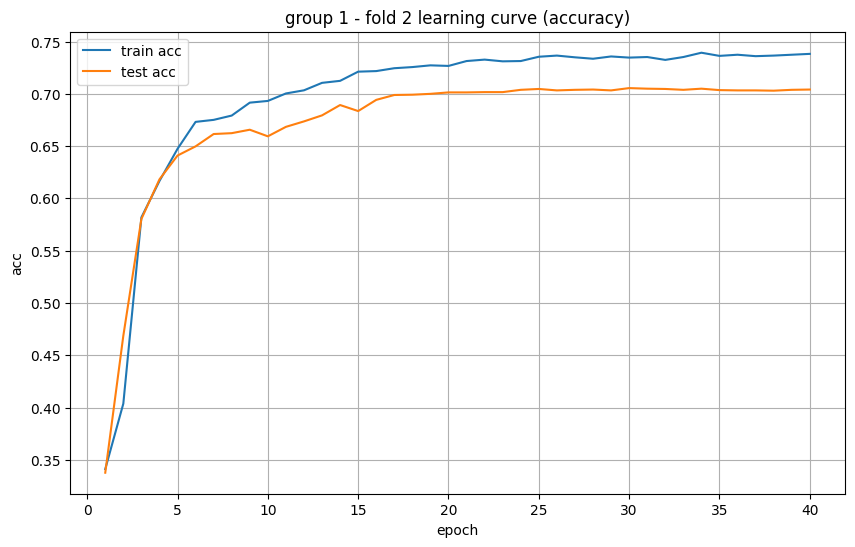

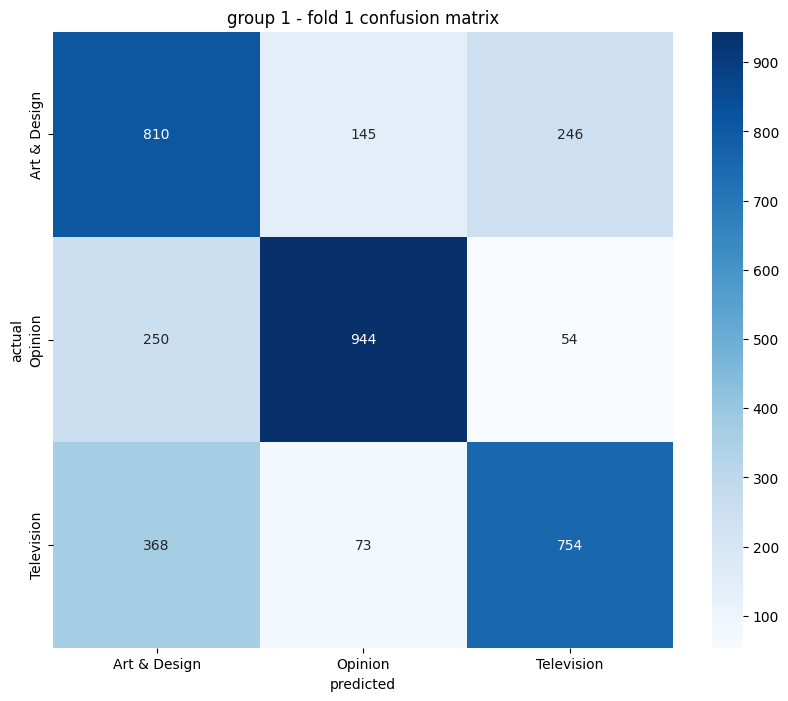

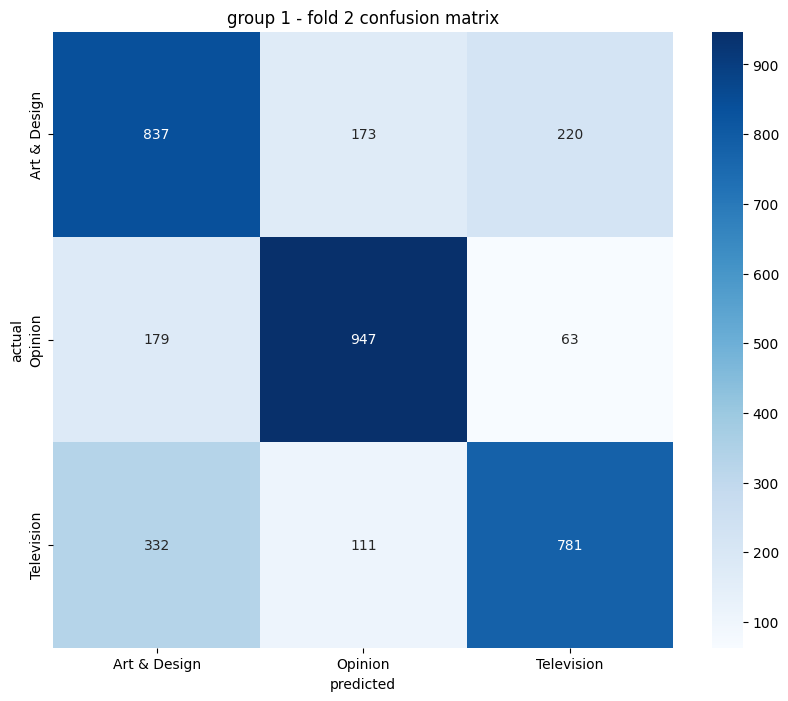


group 2 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1006, train acc: 0.3273
                               test loss: 1.0997, test acc: 0.3350
    epoch 5/40: train loss: 0.8990, train acc: 0.5902
                               test loss: 0.8865, test acc: 0.5951
    epoch 10/40: train loss: 0.8111, train acc: 0.6545
                               test loss: 0.8723, test acc: 0.6043
    epoch 15/40: train loss: 0.7897, train acc: 0.6631
                               test loss: 0.8532, test acc: 0.6197
    epoch 20/40: train loss: 0.7826, train acc: 0.6761
                               test loss: 0.8498, test acc: 0.6272
    epoch 25/40: train loss: 0.7705, train acc: 0.6763
                               test loss: 0.8498, test acc: 0.6244
    epoch 30/40: train loss: 0.7704, train acc: 0.6808
                               test loss: 0.8499, test acc: 0.6275
    epoch 35/40: train loss: 0.7662, train acc: 0.6783
                               test loss: 0.8503, test a

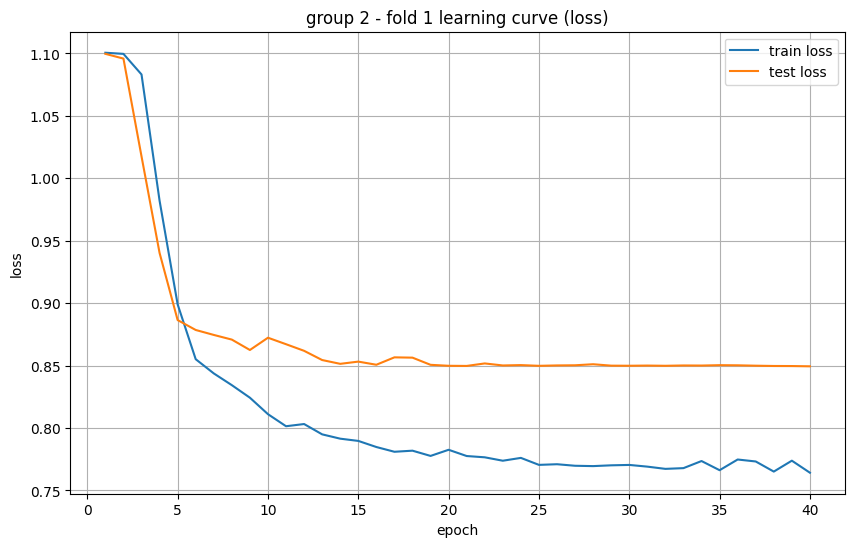

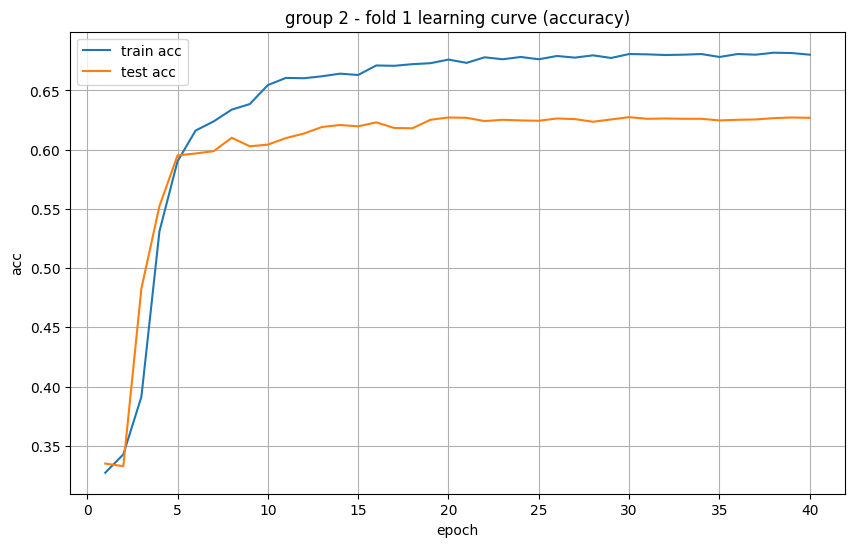

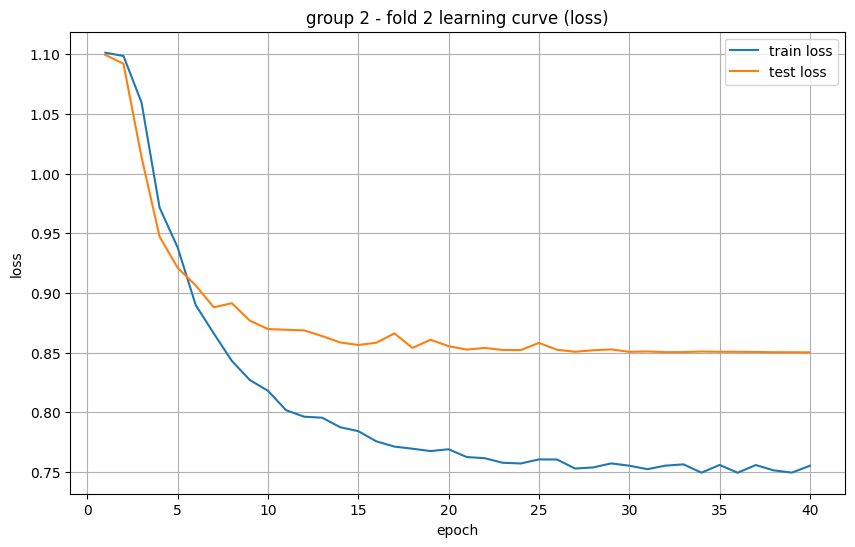

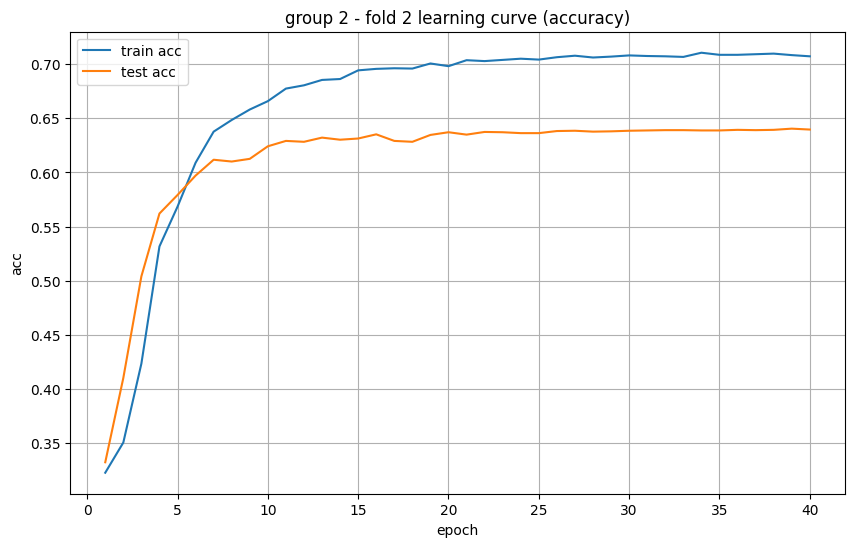

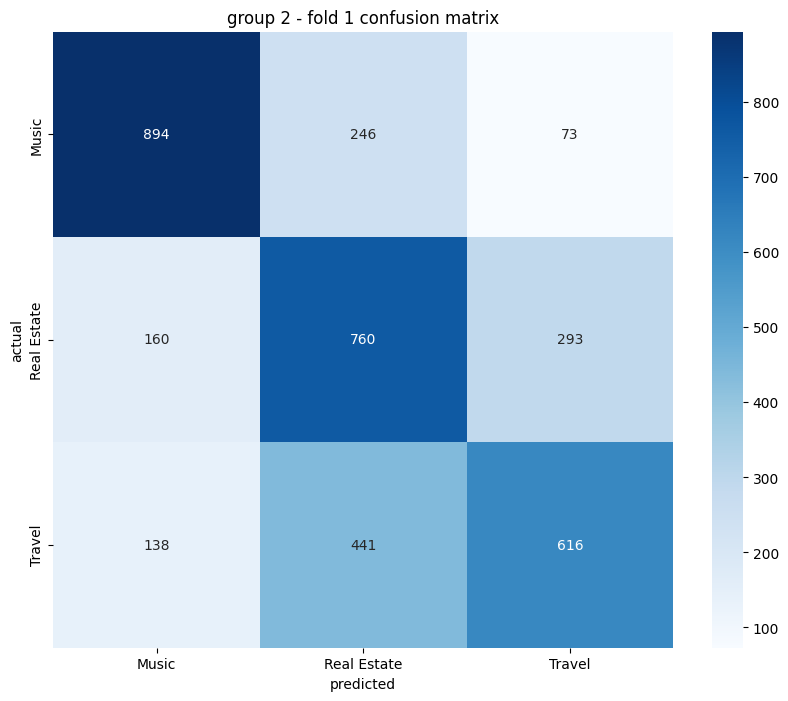

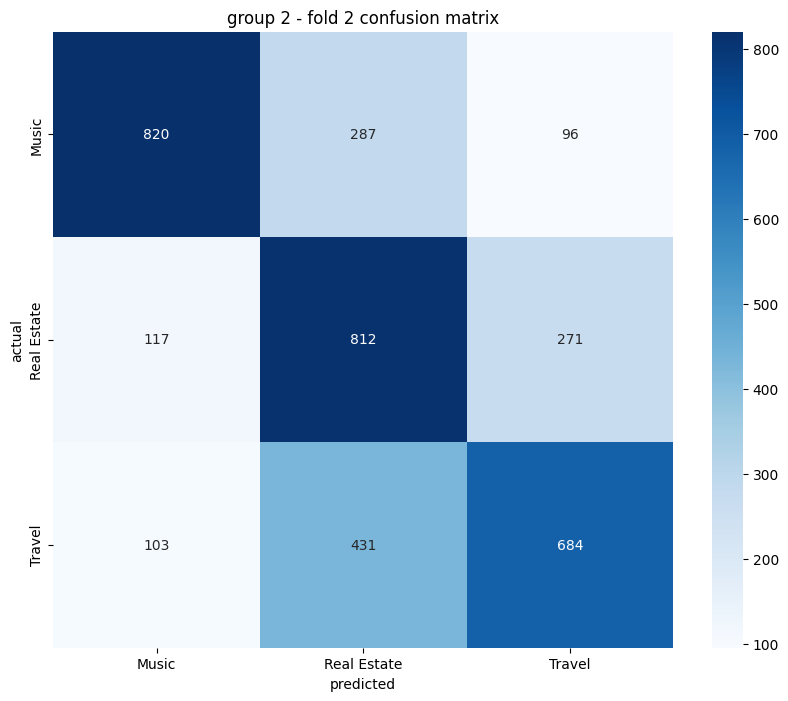


group 3 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1026, train acc: 0.3228
                               test loss: 1.0982, test acc: 0.3427
    epoch 5/40: train loss: 0.9867, train acc: 0.4528
                               test loss: 0.9971, test acc: 0.4517
    epoch 10/40: train loss: 0.8533, train acc: 0.6163
                               test loss: 0.8539, test acc: 0.6188
    epoch 15/40: train loss: 0.7008, train acc: 0.7181
                               test loss: 0.7019, test acc: 0.7250
    epoch 20/40: train loss: 0.6480, train acc: 0.7361
                               test loss: 0.6730, test acc: 0.7308
    epoch 25/40: train loss: 0.6352, train acc: 0.7419
                               test loss: 0.6664, test acc: 0.7322
    epoch 30/40: train loss: 0.6290, train acc: 0.7469
                               test loss: 0.6674, test acc: 0.7303
    epoch 35/40: train loss: 0.6266, train acc: 0.7461
                               test loss: 0.6640, test a

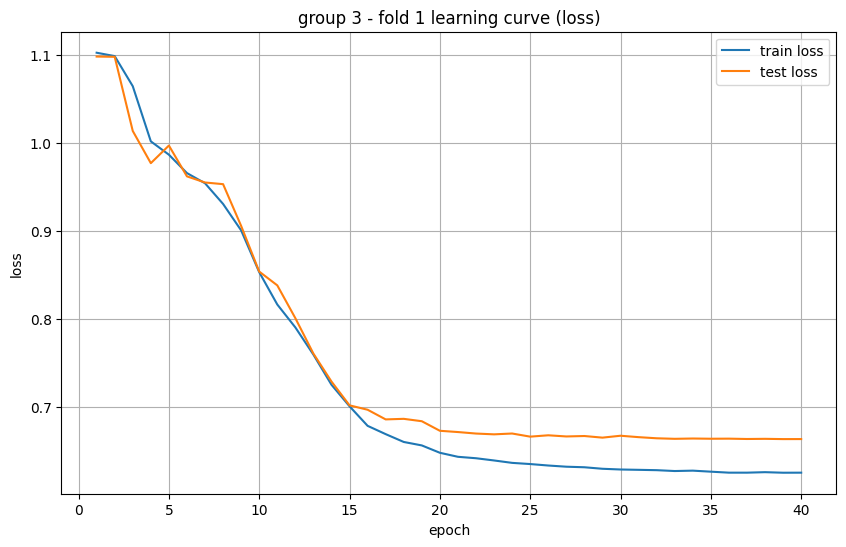

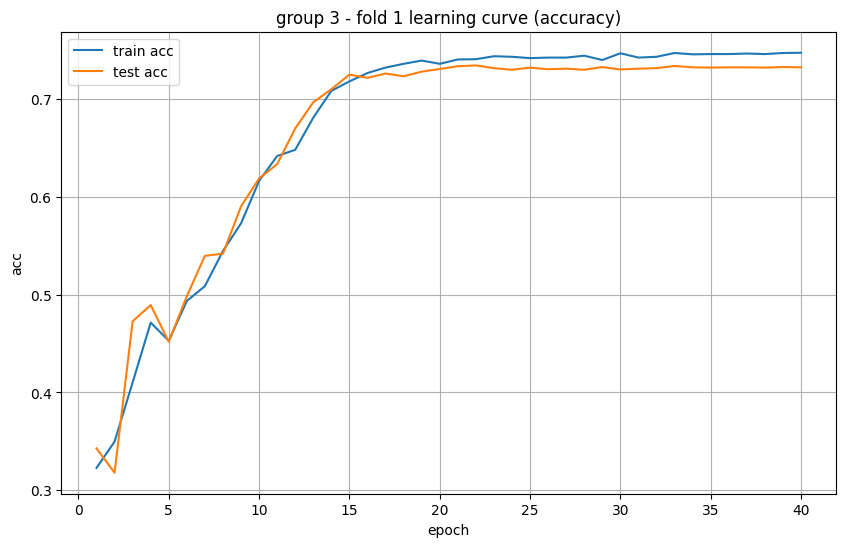

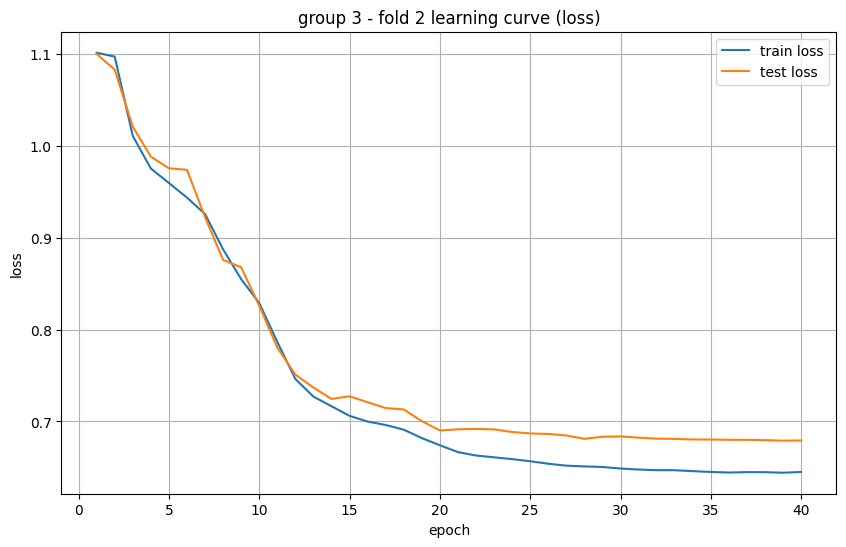

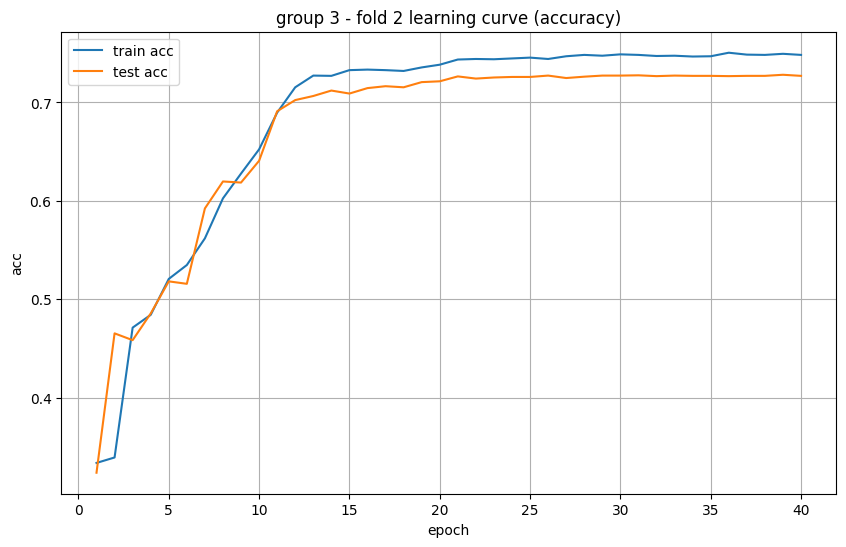

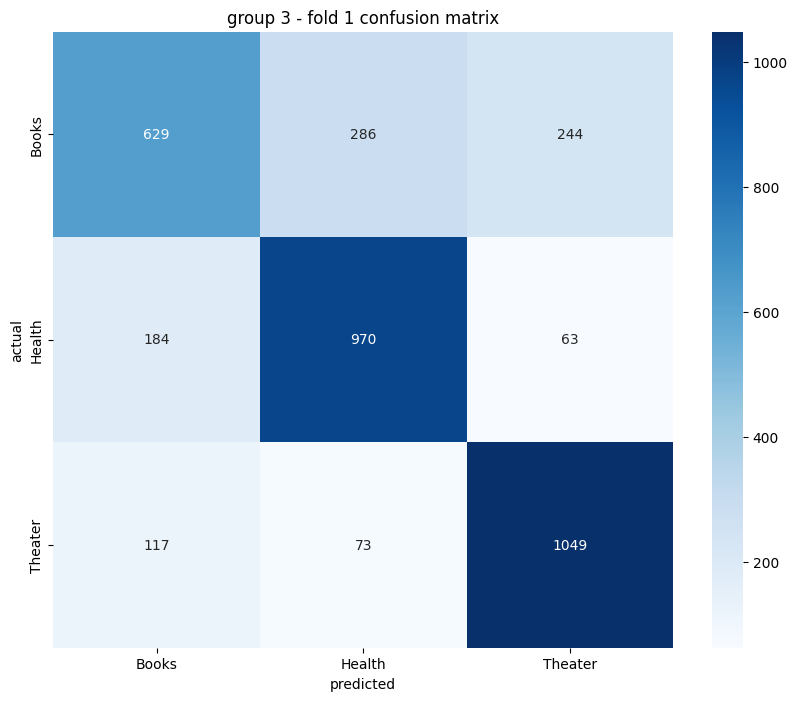

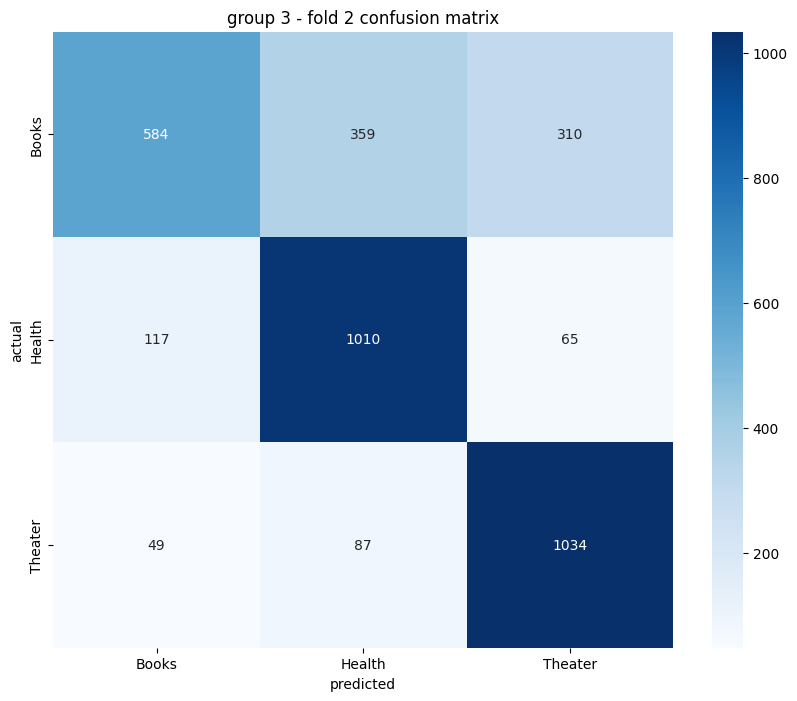


group 4 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1002, train acc: 0.3279
                               test loss: 1.1052, test acc: 0.3223
    epoch 5/40: train loss: 1.0074, train acc: 0.4712
                               test loss: 1.0118, test acc: 0.4529
    epoch 10/40: train loss: 0.9233, train acc: 0.5141
                               test loss: 0.9515, test acc: 0.4936
    epoch 15/40: train loss: 0.8617, train acc: 0.5704
                               test loss: 0.9193, test acc: 0.5370
    epoch 20/40: train loss: 0.8428, train acc: 0.5910
                               test loss: 0.9132, test acc: 0.5446
    epoch 25/40: train loss: 0.8321, train acc: 0.6021
                               test loss: 0.9120, test acc: 0.5479
    epoch 30/40: train loss: 0.8250, train acc: 0.6021
                               test loss: 0.9037, test acc: 0.5535
    epoch 35/40: train loss: 0.8285, train acc: 0.6074
                               test loss: 0.9070, test a

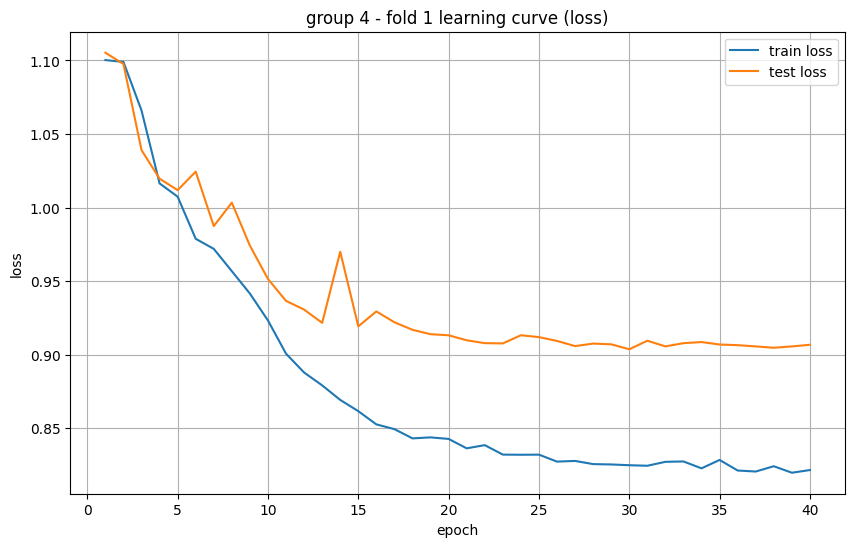

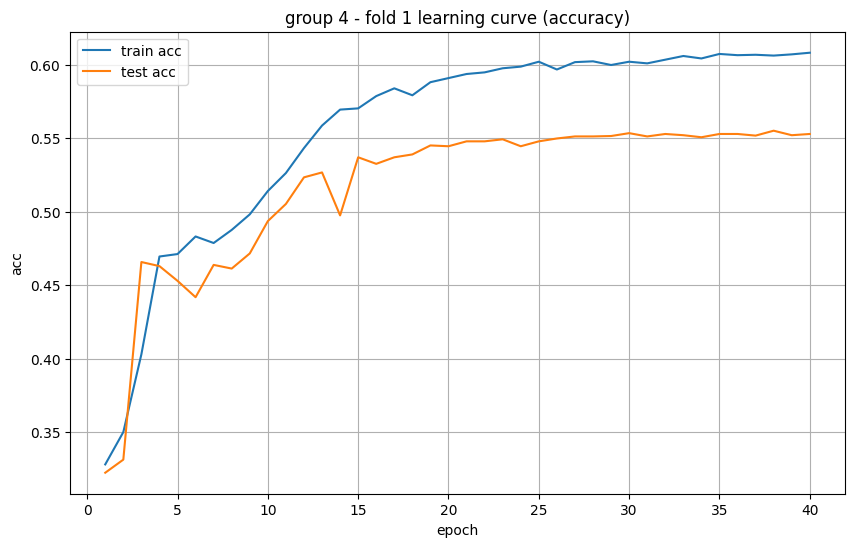

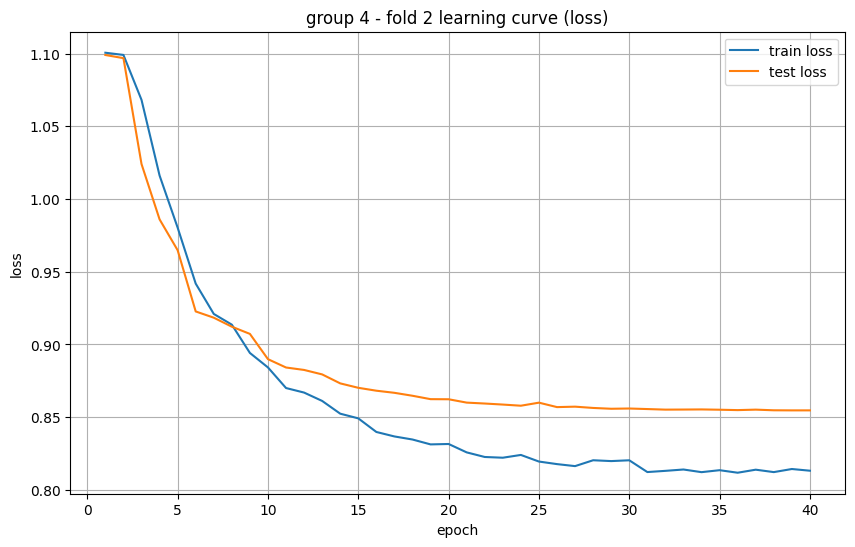

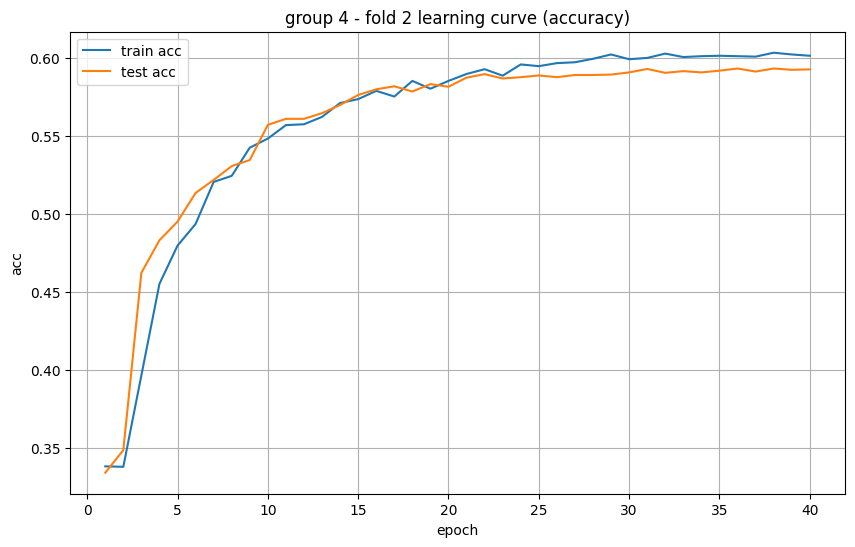

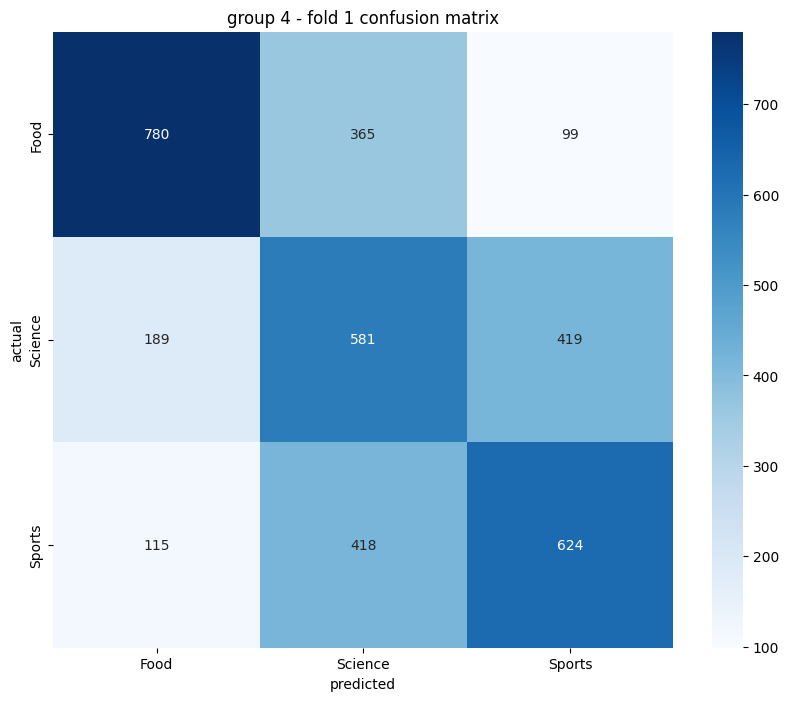

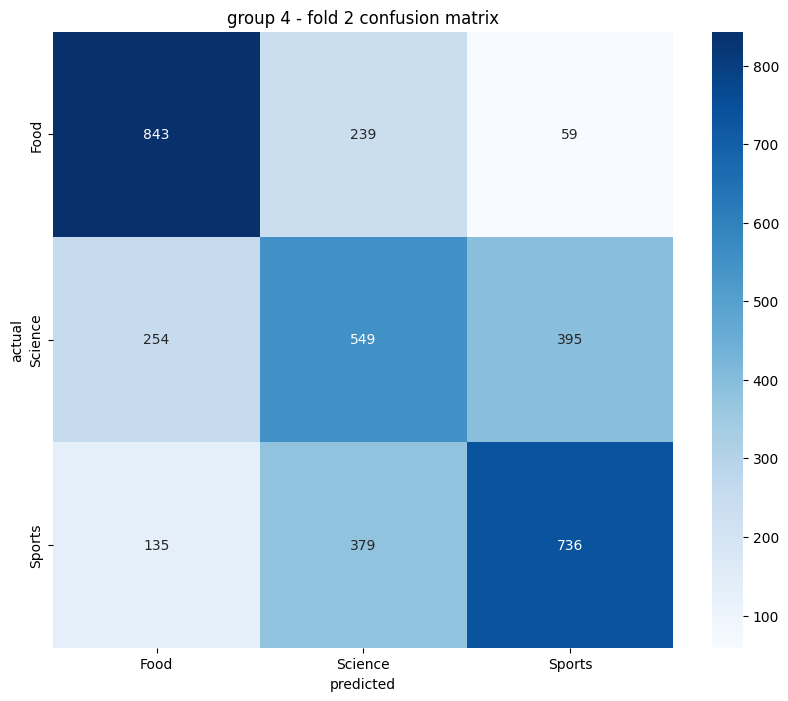


group 5 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1007, train acc: 0.3312
                               test loss: 1.1010, test acc: 0.3308
    epoch 5/40: train loss: 0.9255, train acc: 0.5423
                               test loss: 0.8914, test acc: 0.5603
    epoch 10/40: train loss: 0.7953, train acc: 0.6310
                               test loss: 0.8097, test acc: 0.6059
    epoch 15/40: train loss: 0.7581, train acc: 0.6565
                               test loss: 0.7981, test acc: 0.6185
    epoch 20/40: train loss: 0.7392, train acc: 0.6677
                               test loss: 0.7860, test acc: 0.6264
    epoch 25/40: train loss: 0.7297, train acc: 0.6739
                               test loss: 0.7802, test acc: 0.6306
    epoch 30/40: train loss: 0.7255, train acc: 0.6755
                               test loss: 0.7774, test acc: 0.6311
    epoch 35/40: train loss: 0.7243, train acc: 0.6797
                               test loss: 0.7783, test a

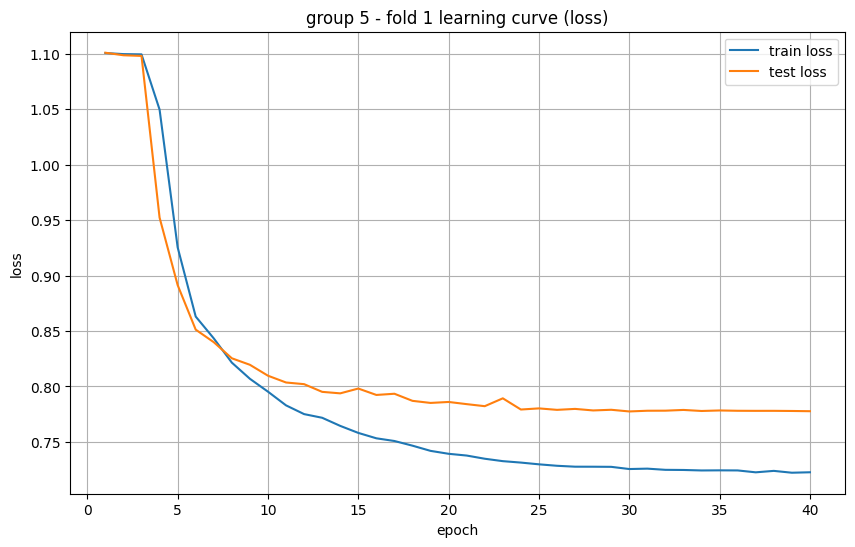

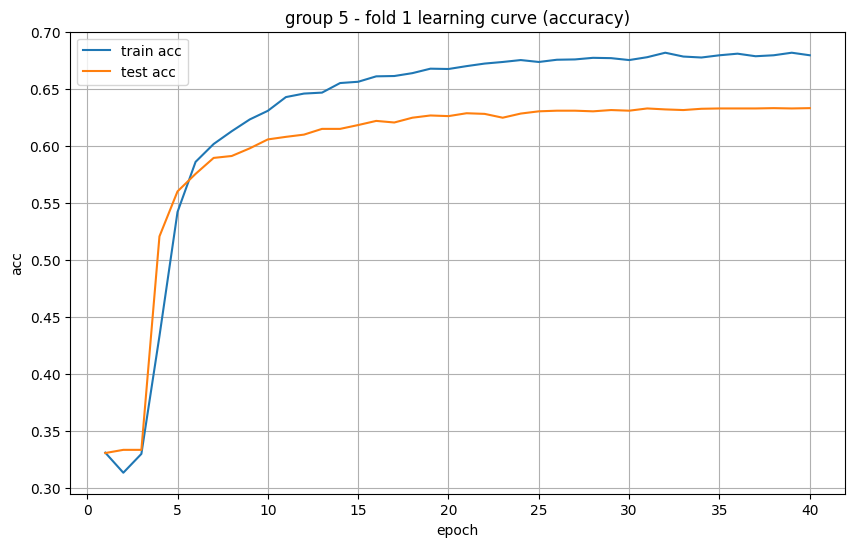

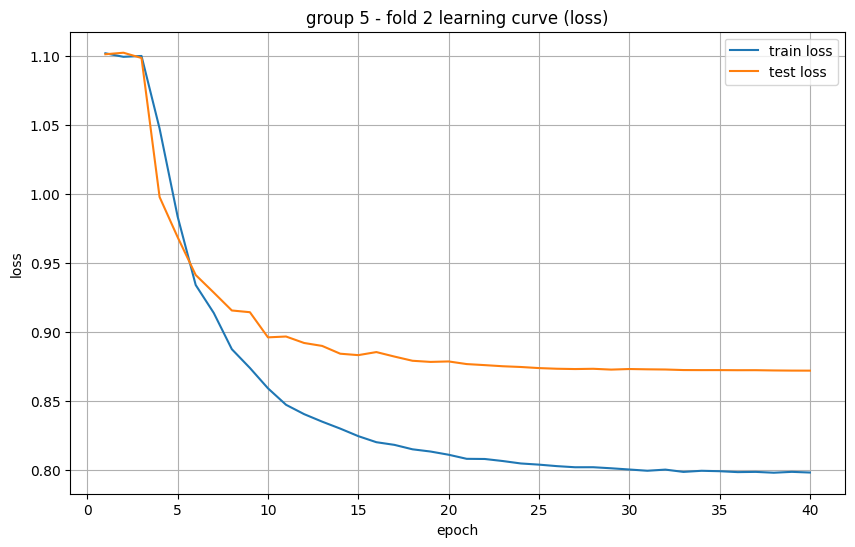

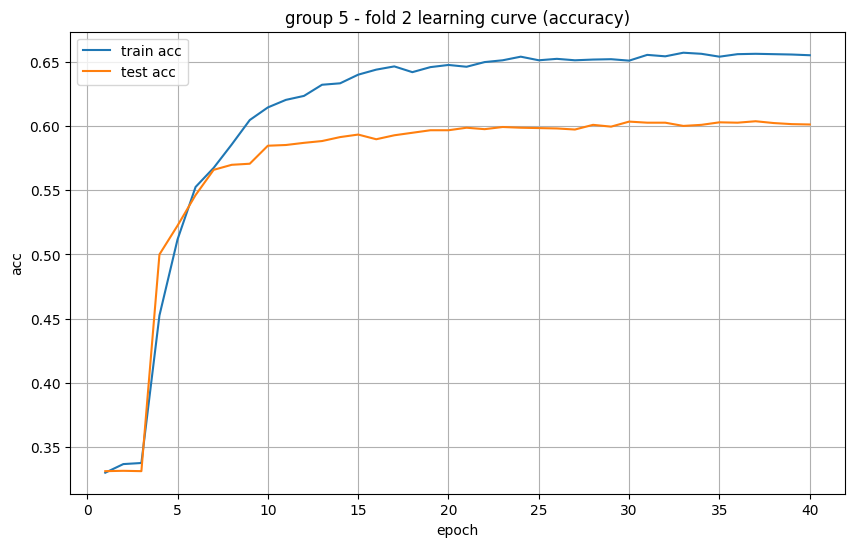

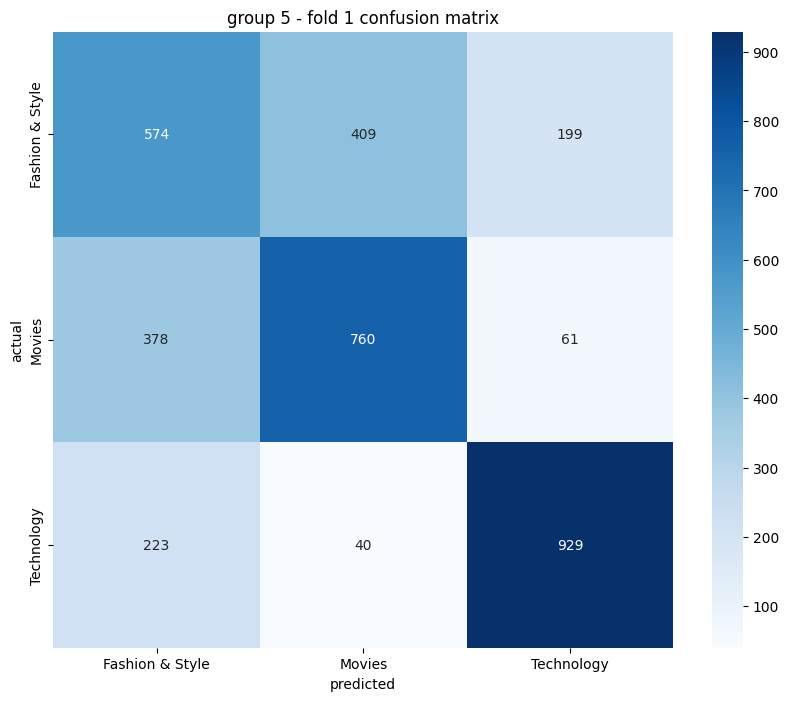

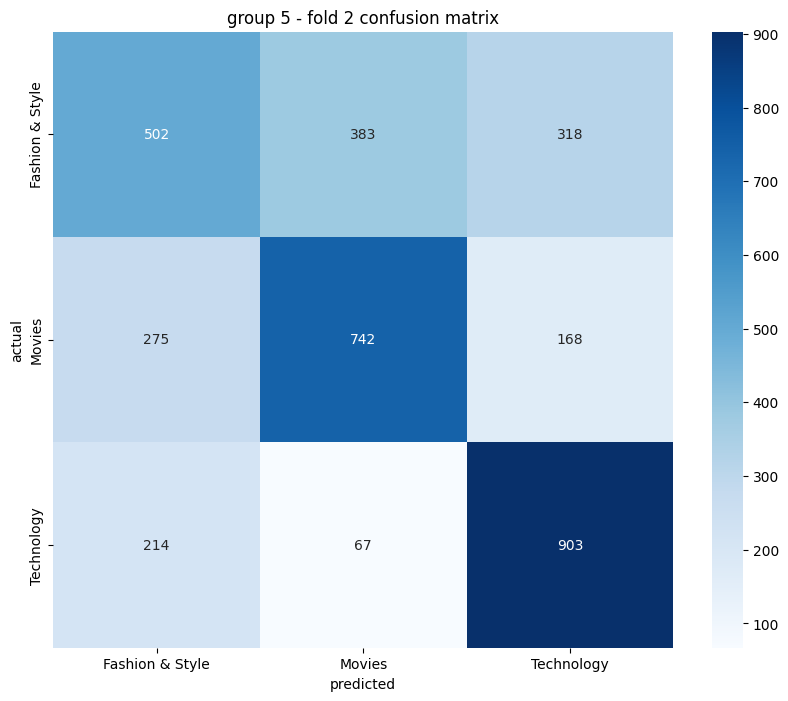


group 6 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1003, train acc: 0.3337
                               test loss: 1.0988, test acc: 0.3441
    epoch 5/40: train loss: 1.0149, train acc: 0.4932
                               test loss: 0.9889, test acc: 0.5239
    epoch 10/40: train loss: 0.9305, train acc: 0.5775
                               test loss: 0.9425, test acc: 0.5605
    epoch 15/40: train loss: 0.9094, train acc: 0.5903
                               test loss: 0.9396, test acc: 0.5585
    epoch 20/40: train loss: 0.9018, train acc: 0.5965
                               test loss: 0.9300, test acc: 0.5704
    epoch 25/40: train loss: 0.8967, train acc: 0.6011
                               test loss: 0.9322, test acc: 0.5698
    epoch 30/40: train loss: 0.8949, train acc: 0.6008
                               test loss: 0.9311, test acc: 0.5713
    epoch 35/40: train loss: 0.8952, train acc: 0.6020
                               test loss: 0.9322, test a

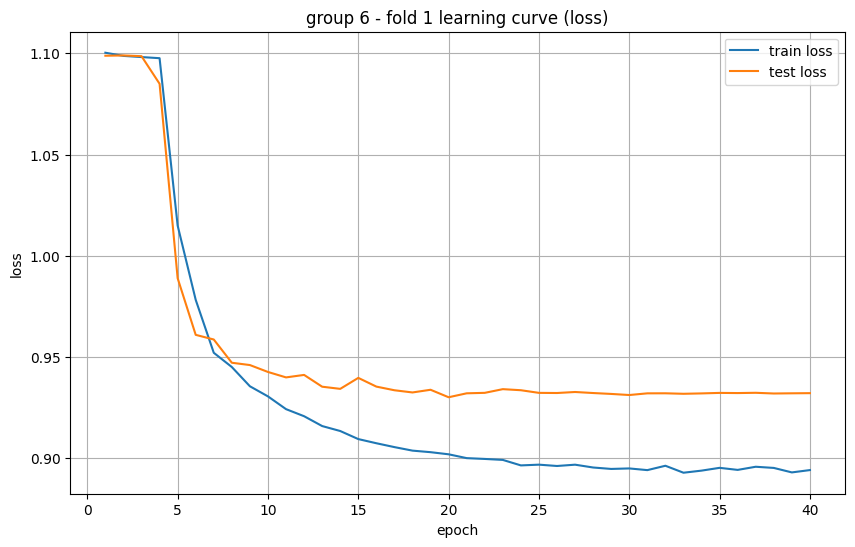

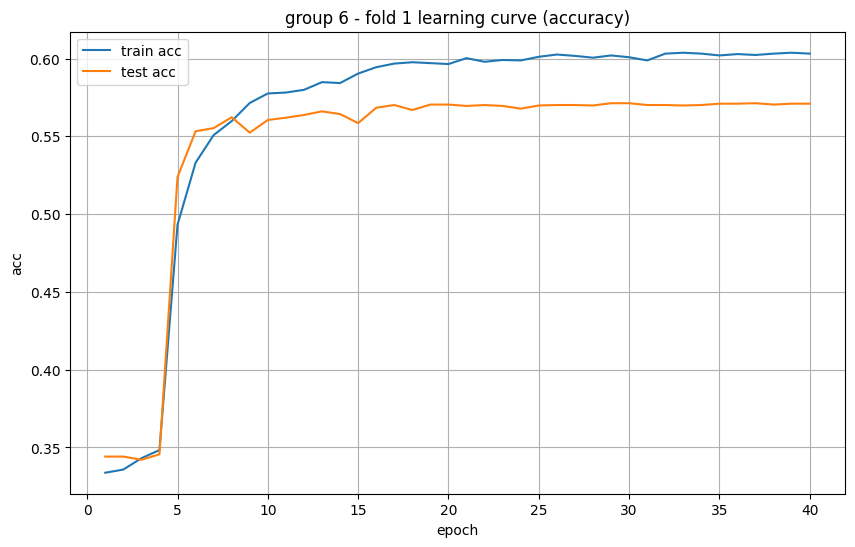

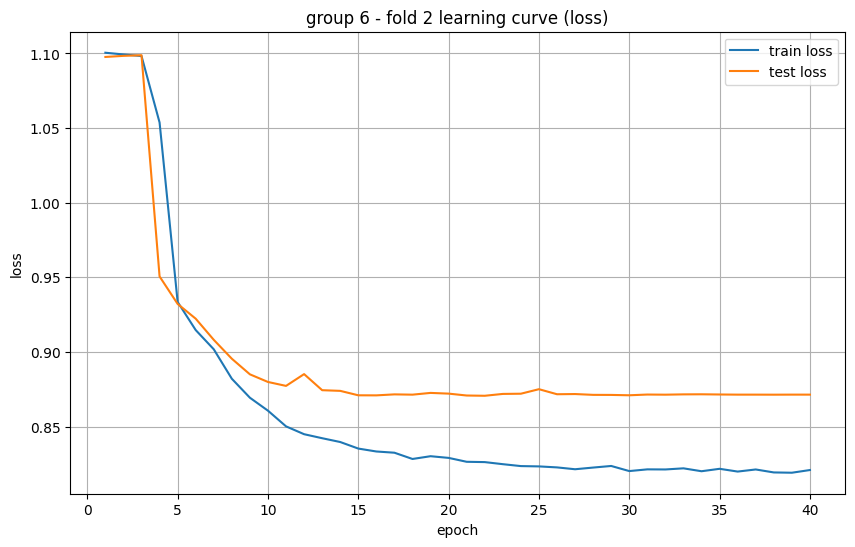

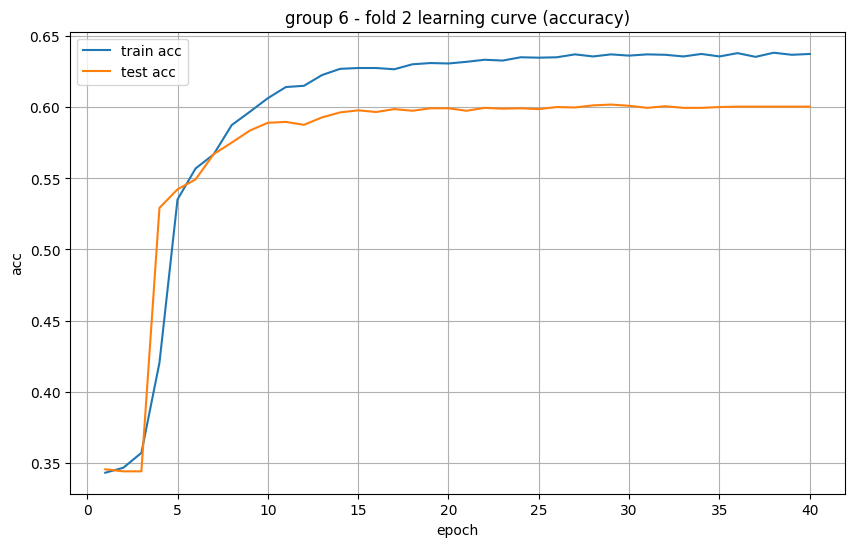

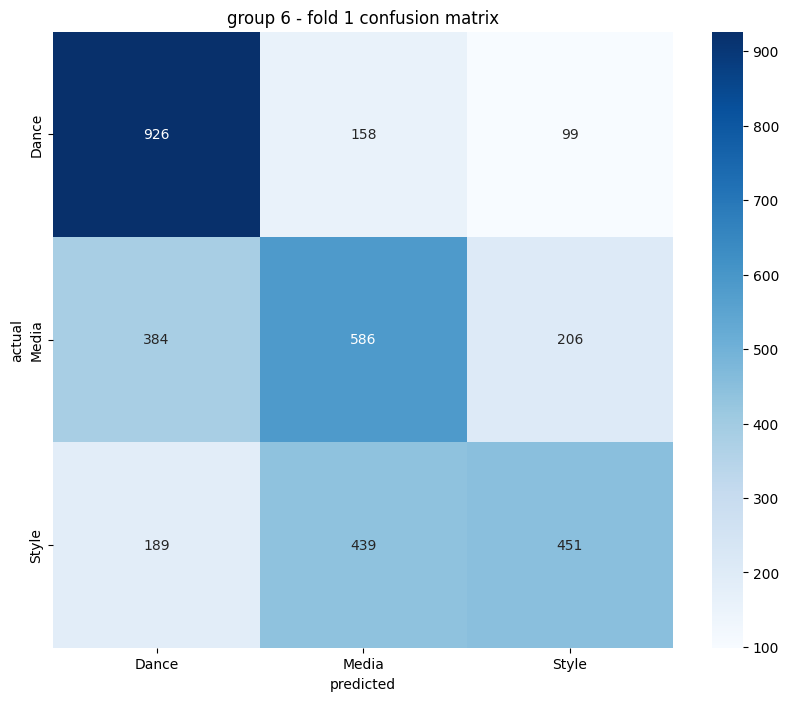

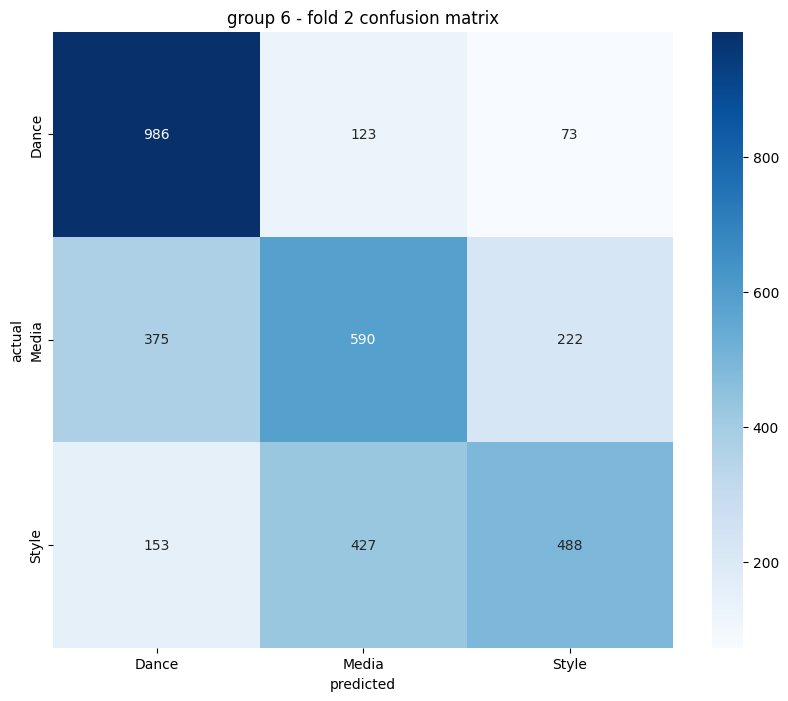


=== 모든 그룹의 요약 결과 ===

그룹 1 - 평균 테스트 정확도: 0.6962
  폴드 1: 테스트 정확도 = 0.6883
  폴드 2: 테스트 정확도 = 0.7041

그룹 2 - 평균 테스트 정확도: 0.6333
  폴드 1: 테스트 정확도 = 0.6269
  폴드 2: 테스트 정확도 = 0.6396

그룹 3 - 평균 테스트 정확도: 0.7297
  폴드 1: 테스트 정확도 = 0.7325
  폴드 2: 테스트 정확도 = 0.7270

그룹 4 - 평균 테스트 정확도: 0.5729
  폴드 1: 테스트 정확도 = 0.5529
  폴드 2: 테스트 정확도 = 0.5929

그룹 5 - 평균 테스트 정확도: 0.6172
  폴드 1: 테스트 정확도 = 0.6334
  폴드 2: 테스트 정확도 = 0.6011

그룹 6 - 평균 테스트 정확도: 0.5857
  폴드 1: 테스트 정확도 = 0.5710
  폴드 2: 테스트 정확도 = 0.6005


In [8]:
EPOCHS = 40
BATCH_SIZE = 32
K_FOLDS = 2
results = []
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
LATENT_DIM = 64
LATENT_SIZE = 64  # Latent의 수
NUM_BLOCKS = 4    # PerceiverBlock의 수
LR = 1e-4

all_learning_curves = []
best_models = {} 

for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)

    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_results = []
    fold_learning_curves = []
    best_fold_acc = 0.0
    best_model = None
    best_valid_loader = None

    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset), start=1):
        print(f"\n  fold {fold}/{K_FOLDS} 처리 중...")

        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True,
                                  num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=g)
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False,
                                 num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=g)

        perceiver = Perceiver(
            input_dim=EMBED_DIM,
            latent_dim=LATENT_DIM,
            latent_size=LATENT_SIZE,
            num_classes=num_classes,
            num_blocks=NUM_BLOCKS,
            self_attn_layers_per_block=1
        )

        model = CombinedModel(
            vocab_size=VOCAB_SIZE,
            embed_dim=EMBED_DIM,
            perceiver_model=perceiver
        )
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LR)  
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        for epoch in range(EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            scheduler.step()

            current_lr = LR
            current_lr = scheduler.get_last_lr()[0]
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f'    epoch {epoch+1}/{EPOCHS}: train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')
                print(f'                               test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')
        if test_acc > best_fold_acc:
            best_fold_acc = test_acc
            best_model = model
            best_valid_loader = test_loader

        fold_learning_curves.append({
            "Fold": fold,
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies
        })

        
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                input_ids_batch = batch['input_ids'].to(device)
                attention_mask_batch = batch['attention_mask'].to(device)  
                labels_batch = batch['labels'].to(device)

                outputs = model(input_ids_batch)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels_batch.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)
        fold_results.append({
            "Fold": fold,
            "Test Accuracy": test_acc,
            "Confusion Matrix": cm,
            "Classification Report": report
        })
    

    # 모델 및 데이터로더 저장장
    model_save_path = f"{model_path}/text_model_{idx}.pkl"
    torch.save(best_model, model_save_path)
    print(f"Group {idx} 최고 모델 저장 완료: {model_save_path}")

    # val_loader_save_path = f"{loader_path}/text_val_loader_{idx}.pkl"
    # with open(val_loader_save_path, 'wb') as f:
    #     pickle.dump(best_valid_loader, f) 
    # print(f"Group {idx} 최고 valid loader 저장 완료: {val_loader_save_path}")
    
    
    # 결과 Analysis
    avg_accuracy = np.mean([fr["Test Accuracy"] for fr in fold_results])
    results.append({
        "Group": idx,
        "Average Test Accuracy": avg_accuracy,
        "Fold Results": fold_results
    })

    all_learning_curves.append({
        "Group": idx,
        "Fold Learning Curves": fold_learning_curves
    })

  
    print(f"\n그룹 {idx}의 {K_FOLDS} 폴드 평균 테스트 정확도: {avg_accuracy:.4f}")

    for fold_result in fold_results:
        print(f"\n  폴드 {fold_result['Fold']} 결과:")
        print(f"    테스트 정확도: {fold_result['Test Accuracy']:.4f}")
        print(pd.DataFrame(fold_result['Classification Report']).transpose())

    for curve in fold_learning_curves:
        fold_idx = curve["Fold"]

        
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_losses"], label="train loss")
        plt.plot(range(1, EPOCHS + 1), curve["test_losses"], label="test loss")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (loss)")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.grid(True)
        plt.show()

   
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_accuracies"], label="train acc")
        plt.plot(range(1, EPOCHS + 1), curve["test_accuracies"], label="test acc")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (accuracy)")
        plt.xlabel("epoch")
        plt.ylabel("acc")
        plt.legend()
        plt.grid(True)
        plt.show()

    
    for fold_result in fold_results:
        fold_idx = fold_result["Fold"]
        cm = fold_result["Confusion Matrix"]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, 
                    yticklabels=label_encoder.classes_)
        plt.title(f"group {idx} - fold {fold_idx} confusion matrix")
        plt.xlabel("predicted")
        plt.ylabel("actual")
        plt.show()

print("\n=== 모든 그룹의 요약 결과 ===")
for result in results:
    group_idx = result["Group"]
    avg_acc = result["Average Test Accuracy"]
    print(f"\n그룹 {group_idx} - 평균 테스트 정확도: {avg_acc:.4f}")
    for fold_result in result["Fold Results"]:
        fold_idx = fold_result["Fold"]
        fold_acc = fold_result["Test Accuracy"]
        print(f"  폴드 {fold_idx}: 테스트 정확도 = {fold_acc:.4f}")

In [9]:
import pickle

file_path = "/home/youlee/perceiver/perceiver/loader/text_val_loader_1.pkl"

with open(file_path, "rb") as file:
    data = pickle.load(file)

type_of_data = type(data)
if hasattr(data, 'shape'):
    data_shape = data.shape
else:
    try:
        data_shape = (len(data), len(data[0]))
    except Exception as e:
        data_shape = f"Cannot determine shape: {e}"

type_of_data, data_shape


(torch.utils.data.dataloader.DataLoader,
 "Cannot determine shape: 'DataLoader' object is not subscriptable")

In [10]:
for batch in data:
  
    if isinstance(batch, dict):
        print({key: value.shape for key, value in batch.items()})

    elif isinstance(batch, tuple):
        print(f"Inputs shape: {batch[0].shape}, Labels shape: {batch[1].shape}")
    else:
        print(f"Unknown batch format: {type(batch)}")
    break  

{'input_ids': torch.Size([32, 128]), 'attention_mask': torch.Size([32, 128]), 'labels': torch.Size([32])}
